<a href="https://colab.research.google.com/github/ghommidhWassim/GNN-variants/blob/main/test_gcn_variants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!python -c "import torch; print(torch.__version__)"


2.6.0+cu124


In [ ]:
!python -c "import torch; print(torch.version.cuda)"



12.4


In [3]:
pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

In [4]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html



Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 131.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 115.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 111.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.6 MB/s eta 0:00:00


In [5]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd
import time

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
# import pyg_lib
import torch_sparse
from sklearn.metrics import f1_score

# PyTorch geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, Amazon
from torch_geometric.loader import ClusterData, ClusterLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from torch_geometric import seed_everything
from torch_geometric.nn.models import GraphSAGE
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
import torch_geometric.transforms as T
import json


**STANDARD GCN pubmed**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data = dataset[0].to(device)  # Get the first graph object.
data

Using device: cuda


Processing...
Done!


Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

In [ ]:
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')

Number of nodes:          19717
Number of edges:          88648
Average node degree:      4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


In [ ]:
def clean_gpu_memory():
    """Cleans GPU memory without fully resetting the CUDA context"""
    import gc
    gc.collect()  # Python garbage collection
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # PyTorch cache
        torch.cuda.reset_peak_memory_stats()  # Reset tracking
        print(f"Memory after cleanup: {torch.cuda.memory_allocated()/1024**2:.2f} MB")


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return F.log_softmax(x, dim=-1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features, 64, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print(model)

GCN(
  (conv1): GCNConv(500, 64)
  (conv2): GCNConv(64, 3)
)


In [ ]:
def train(data, mask):
  model.train()
  optimizer.zero_grad()  # Clear gradients.
  out = model(data.x, data.edge_index)  # Perform a single forward pass.
  loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
  loss.backward()  # Derive gradients.
  optimizer.step()  # Update parameters based on gradients.
  return loss

def test(data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    true = data.y[mask].cpu()
    pred = pred[mask].cpu()
    acc = (pred == true).sum().item() / mask.sum().item()
    micro_f1 = f1_score(true, pred, average='micro')
    return acc, micro_f1


In [ ]:

#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

res=[]
training=[]
memory=[]
for i in range(10):
  clean_gpu_memory()
  start_time = time.time()
  for epoch in range(1, 101):
      loss = train(data, data.train_mask)
      train_acc, train_f1 = test(data, data.train_mask)
      val_acc, val_f1 = test(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
  end_time = time.time()
  test_acc,f1_micro = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)
  memory.append(torch.cuda.max_memory_allocated()/1024**2)
print(f"Current GPU memory: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
print(f"Max GPU memory used: {torch.cuda.max_memory_allocated()/1024**2:.2f} MB")
print(f"Time taken: {end_time - start_time:.2f} seconds")

Memory after cleanup: 39.69 MB
Epoch: 001, Train Acc: 0.6500, Train F1: 0.6500, Val Acc: 0.5560, Val F1: 0.5560
Epoch: 002, Train Acc: 0.8833, Train F1: 0.8833, Val Acc: 0.7140, Val F1: 0.7140
Epoch: 003, Train Acc: 0.8833, Train F1: 0.8833, Val Acc: 0.7240, Val F1: 0.7240
Epoch: 004, Train Acc: 0.8833, Train F1: 0.8833, Val Acc: 0.7260, Val F1: 0.7260
Epoch: 005, Train Acc: 0.9000, Train F1: 0.9000, Val Acc: 0.7280, Val F1: 0.7280
Epoch: 006, Train Acc: 0.9167, Train F1: 0.9167, Val Acc: 0.7320, Val F1: 0.7320
Epoch: 007, Train Acc: 0.9167, Train F1: 0.9167, Val Acc: 0.7320, Val F1: 0.7320
Epoch: 008, Train Acc: 0.9167, Train F1: 0.9167, Val Acc: 0.7340, Val F1: 0.7340
Epoch: 009, Train Acc: 0.9167, Train F1: 0.9167, Val Acc: 0.7440, Val F1: 0.7440
Epoch: 010, Train Acc: 0.9167, Train F1: 0.9167, Val Acc: 0.7440, Val F1: 0.7440
Epoch: 011, Train Acc: 0.9167, Train F1: 0.9167, Val Acc: 0.7440, Val F1: 0.7440
Epoch: 012, Train Acc: 0.9333, Train F1: 0.9333, Val Acc: 0.7460, Val F1: 0.74

In [ ]:
std_acc = np.std(res)
mean_test_acc = np.mean(res)
print(f"Test Accuracy: {mean_test_acc:.4f} ± {std_acc:.4f}")
std_training = np.std(training)
mean_training = np.mean(training)
print(f"training time: {mean_training:.4f} ± {std_training:.4f}")
std_memory = np.std(memory)
mean_memory = np.mean(memory)
print(f"memory used: {mean_memory:.4f} ± {std_memory:.4f}")

Test Accuracy: 0.7577 ± 0.0017
training time: 1.7659 ± 0.3984
memory used: 121.8216 ± 2.7152


In [ ]:
out = model(data.x, data.edge_index)

In [ ]:
def gcn_memory_usage(num_layers: int, num_nodes: int, feat_dim: int, use_bytes: bool = True):

    # Each embedding matrix is size |V| × K floats, there are L such layers
    num_emb_floats = num_layers * num_nodes * feat_dim
    # Each weight matrix is K × K floats per layer
    num_weight_floats = num_layers * feat_dim * feat_dim

    if use_bytes:
        bytes_per_float = 4  # assuming float32
        embeddings_bytes = num_emb_floats * bytes_per_float
        weights_bytes = num_weight_floats * bytes_per_float
        total_bytes = embeddings_bytes + weights_bytes
        return embeddings_bytes, weights_bytes, total_bytes
    else:
        return num_emb_floats, num_weight_floats, num_emb_floats + num_weight_floats


e, w, t = gcn_memory_usage(2, data.num_nodes, out.shape[1])
print(f"Embeddings: {e/1e6:.1f} MB, Weights: {w*4/1e6:.1f} MB, Total: {t/1e6:.1f} MB")
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "GCN full-batch",
    "accuracy": test_acc,
    "f1_micro":f1_micro,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "embedding_storage":e,
    "Weight_Matrices":w,
    "Total_Memory":t
}

with open("GCN_full_batch_pubmed_results.json", "w") as f:
    json.dump(metrics, f)

Embeddings: 0.5 MB, Weights: 0.0 MB, Total: 0.5 MB


**Cora dataset**

In [ ]:
clean_gpu_memory()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data = dataset[0].to(device)  # Get the first graph object.
data
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features, 64, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

res=[]
training=[]
memory=[]
for i in range(10):
  clean_gpu_memory()
  start_time = time.time()
  for epoch in range(1, 101):
      loss = train(data, data.train_mask)
      train_acc, train_f1 = test(data, data.train_mask)
      val_acc, val_f1 = test(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
  end_time = time.time()
  test_acc,f1_micro = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)
  memory.append(torch.cuda.max_memory_allocated()/1024**2)


Memory after cleanup: 56.31 MB
Using device: cuda


Processing...
Done!


Number of nodes:          2708
Number of edges:          10556
Average node degree:      3.90
Number of training nodes: 140
Training node label rate: 0.052
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True
Memory after cleanup: 71.65 MB
Epoch: 001, Train Acc: 0.6000, Train F1: 0.6000, Val Acc: 0.4540, Val F1: 0.4540
Epoch: 002, Train Acc: 0.8071, Train F1: 0.8071, Val Acc: 0.4700, Val F1: 0.4700
Epoch: 003, Train Acc: 0.9071, Train F1: 0.9071, Val Acc: 0.5900, Val F1: 0.5900
Epoch: 004, Train Acc: 0.9500, Train F1: 0.9500, Val Acc: 0.6400, Val F1: 0.6400
Epoch: 005, Train Acc: 0.9571, Train F1: 0.9571, Val Acc: 0.6580, Val F1: 0.6580
Epoch: 006, Train Acc: 0.9571, Train F1: 0.9571, Val Acc: 0.6900, Val F1: 0.6900
Epoch: 007, Train Acc: 0.9500, Train F1: 0.9500, Val Acc: 0.6920, Val F1: 0.6920
Epoch: 008, Train Acc: 0.9643, Train F1: 0.9643, Val Acc: 0.6900, Val F1: 0.6900
Epoch: 009, Train Acc: 0.9571, Train F1: 0.9571, Val Acc: 0.6880, Val 

In [ ]:
std_acc = np.std(res)
mean_test_acc = np.mean(res)
print(f"Test Accuracy: {mean_test_acc:.4f} ± {std_acc:.4f}")
std_training = np.std(training)
mean_training = np.mean(training)
print(f"training time: {mean_training:.4f} ± {std_training:.4f}")
std_memory = np.std(memory)
mean_memory = np.mean(memory)
print(f"memory used: {mean_memory:.4f} ± {std_memory:.4f}")

Test Accuracy: 0.7817 ± 0.0034
training time: 1.4787 ± 0.2906
memory used: 80.4691 ± 0.5184


**Citeseer dataset**

In [ ]:
clean_gpu_memory()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data = dataset[0].to(device)  # Get the first graph object.
data
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features, 64, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

res=[]
training=[]
memory=[]

for i in range(10):
  clean_gpu_memory()
  start_time = time.time()

  for epoch in range(1, 101):
      loss = train(data, data.train_mask)
      train_acc, train_f1 = test(data, data.train_mask)
      val_acc, val_f1 = test(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')


  end_time = time.time()
  test_acc,f1_micro = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)
  memory.append(torch.cuda.max_memory_allocated()/1024**2)


std_acc = np.std(res)
mean_test_acc = np.mean(res)
print(f"Test Accuracy: {mean_test_acc:.4f} ± {std_acc:.4f}")
std_training = np.std(training)
mean_training = np.mean(training)
print(f"training time: {mean_training:.4f} ± {std_training:.4f}")
std_memory = np.std(memory)
mean_memory = np.mean(memory)
print(f"memory used: {mean_memory:.4f} ± {std_memory:.4f}")

Memory after cleanup: 72.22 MB
Using device: cuda


Processing...
Done!


Number of nodes:          3327
Number of edges:          9104
Average node degree:      2.74
Number of training nodes: 120
Training node label rate: 0.036
Has isolated nodes:       True
Has self-loops:           False
Is undirected:            True
Memory after cleanup: 104.60 MB
Epoch: 001, Train Acc: 0.7083, Train F1: 0.7083, Val Acc: 0.4140, Val F1: 0.4140
Epoch: 002, Train Acc: 0.7167, Train F1: 0.7167, Val Acc: 0.3480, Val F1: 0.3480
Epoch: 003, Train Acc: 0.8000, Train F1: 0.8000, Val Acc: 0.3980, Val F1: 0.3980
Epoch: 004, Train Acc: 0.9167, Train F1: 0.9167, Val Acc: 0.4860, Val F1: 0.4860
Epoch: 005, Train Acc: 0.9333, Train F1: 0.9333, Val Acc: 0.5320, Val F1: 0.5320
Epoch: 006, Train Acc: 0.9500, Train F1: 0.9500, Val Acc: 0.5640, Val F1: 0.5640
Epoch: 007, Train Acc: 0.9417, Train F1: 0.9417, Val Acc: 0.6040, Val F1: 0.6040
Epoch: 008, Train Acc: 0.9583, Train F1: 0.9583, Val Acc: 0.6280, Val F1: 0.6280
Epoch: 009, Train Acc: 0.9583, Train F1: 0.9583, Val Acc: 0.6520, Val F

**Amazon dataset**

In [ ]:
clean_gpu_memory()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
dataset = Amazon(
        root='data/Amazon',
        name='Computers',
        transform=T.Compose([
        NormalizeFeatures(),          # feature‑wise ℓ₂ normalisation
        RandomNodeSplit(              # ⇦ add a split transform
                split='train_rest',       # 10% val, 10% test by default
                num_val=0.1,
                num_test=0.1,
                num_splits=1,
            )
        ])
    )
num_features = dataset.num_features
num_classes = dataset.num_classes
data = dataset[0].to(device)  # Get the first graph object.
data
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features, 64, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

res=[]
training=[]
memory=[]

for i in range (10):
  clean_gpu_memory()
  start_time = time.time()

  for epoch in range(1, 101):
      loss = train(data, data.train_mask)
      train_acc, train_f1 = test(data, data.train_mask)
      val_acc, val_f1 = test(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')


  end_time = time.time()
  test_acc,f1_micro = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)
  memory.append(torch.cuda.max_memory_allocated()/1024**2)


std_acc = np.std(res)
mean_test_acc = np.mean(res)
print(f"Test Accuracy: {mean_test_acc:.4f} ± {std_acc:.4f}")
std_training = np.std(training)
mean_training = np.mean(training)
print(f"training time: {mean_training:.4f} ± {std_training:.4f}")
std_memory = np.std(memory)
mean_memory = np.mean(memory)
print(f"memory used: {mean_memory:.4f} ± {std_memory:.4f}")

Memory after cleanup: 106.61 MB
Using device: cuda


Processing...
Done!


Number of nodes:          13752
Number of edges:          491722
Average node degree:      35.76
Number of training nodes: 11002
Training node label rate: 0.800
Has isolated nodes:       True
Has self-loops:           False
Is undirected:            True
Memory after cleanup: 107.84 MB
Epoch: 001, Train Acc: 0.3778, Train F1: 0.3778, Val Acc: 0.3578, Val F1: 0.3578
Epoch: 002, Train Acc: 0.3778, Train F1: 0.3778, Val Acc: 0.3578, Val F1: 0.3578
Epoch: 003, Train Acc: 0.3778, Train F1: 0.3778, Val Acc: 0.3578, Val F1: 0.3578
Epoch: 004, Train Acc: 0.3778, Train F1: 0.3778, Val Acc: 0.3578, Val F1: 0.3578
Epoch: 005, Train Acc: 0.3778, Train F1: 0.3778, Val Acc: 0.3578, Val F1: 0.3578
Epoch: 006, Train Acc: 0.3778, Train F1: 0.3778, Val Acc: 0.3578, Val F1: 0.3578
Epoch: 007, Train Acc: 0.3778, Train F1: 0.3778, Val Acc: 0.3578, Val F1: 0.3578
Epoch: 008, Train Acc: 0.3778, Train F1: 0.3778, Val Acc: 0.3578, Val F1: 0.3578
Epoch: 009, Train Acc: 0.3778, Train F1: 0.3778, Val Acc: 0.3578,

In [ ]:
out = model(data.x, data.edge_index)
print(out.shape[1])


10


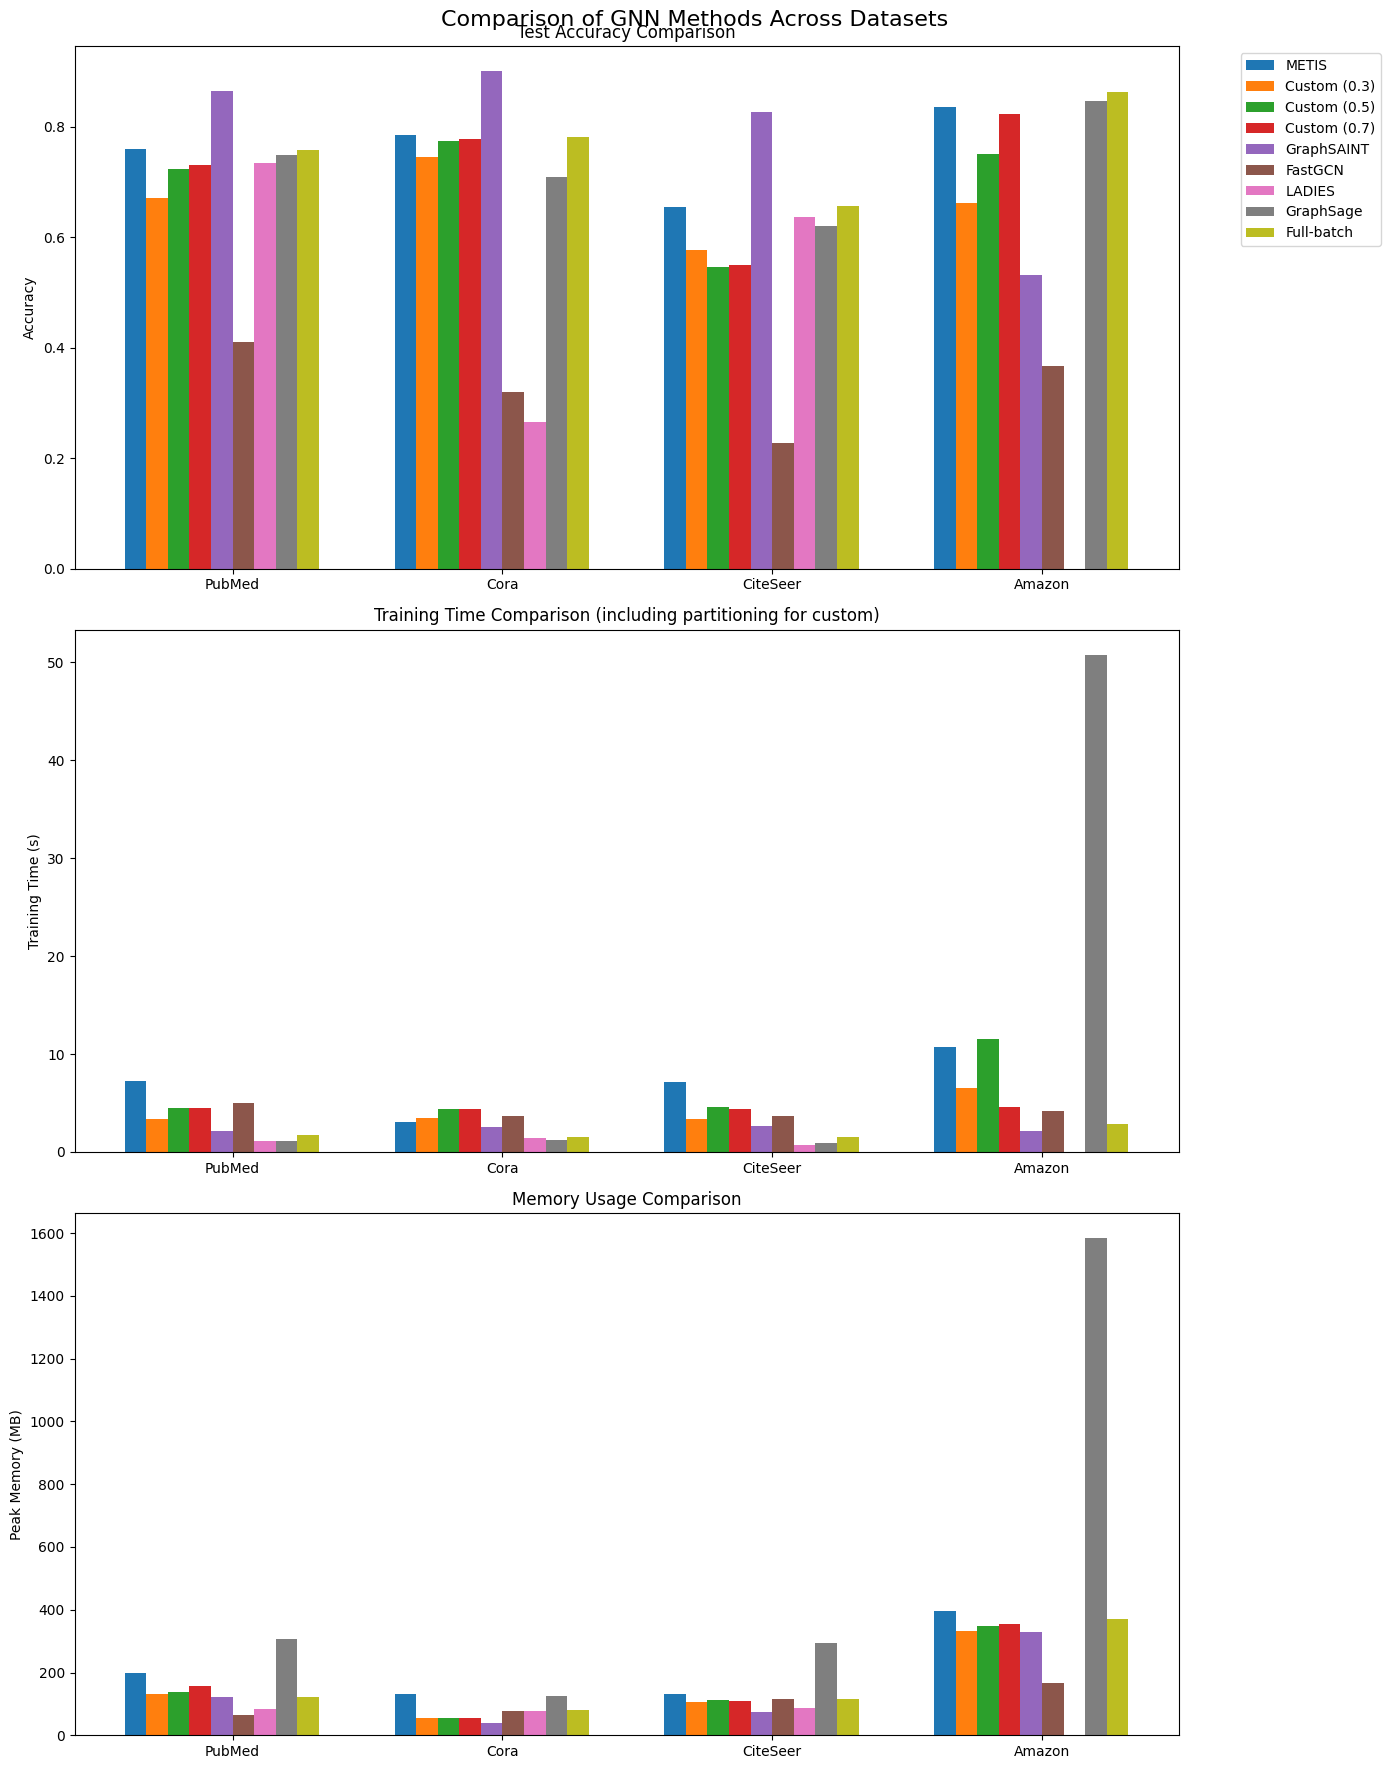

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data organized by dataset
datasets = ['PubMed', 'Cora', 'CiteSeer', 'Amazon']
methods = ['METIS', 'Custom (0.3)', 'Custom (0.5)', 'Custom (0.7)', 'GraphSAINT', 'FastGCN', 'LADIES', 'GraphSage', 'Full-batch']

# Accuracy data
accuracy_data = {
    'PubMed': [0.7606, 0.6703, 0.7245, 0.7302, 0.8640, 0.4107, 0.7341, 0.7491, 0.7577],
    'Cora': [0.7848, 0.7451, 0.7735, 0.7779, 0.9007, 0.3190, 0.2649, 0.7090, 0.7817],
    'CiteSeer': [0.6549, 0.5765, 0.5461, 0.5505, 0.8262, 0.2269, 0.6364, 0.6213, 0.6565],
    'Amazon': [0.8364, 0.6629, 0.7508, 0.8231, 0.5311, 0.3665, np.nan, 0.8465, 0.8636]
}

# Training time data (custom includes partitioning time)
training_time_data = {
    'PubMed': [7.2276, 1.3849+2, 1.4803+3, 1.5184+3, 2.1456, 4.9867, 1.1456, 1.0858, 1.7659],
    'Cora': [3.0506, 1.4223+2, 1.3691+3, 1.4090+3, 2.5573, 3.6985, 1.4322, 1.1880, 1.4787],
    'CiteSeer': [7.0916, 1.3875+2, 1.5413+3, 1.4205+3, 2.6561, 3.6487, 0.6941, 0.9404, 1.4779],
    'Amazon': [10.6898, 1.5058+5, 1.5410+10, 1.5576+3, 2.1290, 4.1470, np.nan, 50.7888, 2.8797]
}

# Memory data
memory_data = {
    'PubMed': [197.3491, 132.8032, 138.9482, 157.2764, 120.7075, 64.7393, 83.0446, 307.0199, 121.8216],
    'Cora': [131.4146, 53.8389, 56.0586, 55.7974, 40.6787, 77.9736, 76.4849, 126.1700, 80.4691],
    'CiteSeer': [130.4863, 107.2163, 111.3906, 110.5718, 75.0396, 115.5054, 86.2959, 293.4229, 114.6146],
    'Amazon': [396.4609, 332.9848, 347.2715, 355.8213, 330.0366, 165.0552, np.nan, 1585.0513, 369.3161]
}

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
fig.suptitle('Comparison of GNN Methods Across Datasets', fontsize=16)

# Plot accuracy
ax = axes[0]
x = np.arange(len(datasets))
width = 0.08
for i, method in enumerate(methods):
    values = [accuracy_data[dataset][i] for dataset in datasets]
    ax.bar(x + i*width - (len(methods)*width/2), values, width, label=method)
ax.set_ylabel('Accuracy')
ax.set_title('Test Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot training time
ax = axes[1]
for i, method in enumerate(methods):
    values = [training_time_data[dataset][i] for dataset in datasets]
    ax.bar(x + i*width - (len(methods)*width/2), values, width, label=method)
ax.set_ylabel('Training Time (s)')
ax.set_title('Training Time Comparison (including partitioning for custom)')
ax.set_xticks(x)
ax.set_xticklabels(datasets)

# Plot memory
ax = axes[2]
for i, method in enumerate(methods):
    values = [memory_data[dataset][i] for dataset in datasets]
    ax.bar(x + i*width - (len(methods)*width/2), values, width, label=method)
ax.set_ylabel('Peak Memory (MB)')
ax.set_title('Memory Usage Comparison')
ax.set_xticks(x)
ax.set_xticklabels(datasets)

plt.tight_layout()
plt.show()

In [ ]:
!python pytorch_ladies.py --cuda 0 --dataset cora

cora ladies
/content/LADIES/pytorch_ladies.py:190: DeprecationWarning: Please import `lil_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.lil` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(feat_data) == scipy.sparse.lil.lil_matrix:
----------
Epoch: 0 (0.8s) Train Loss: 1.83    Valid Loss: 1.75 Valid F1: 0.674
Epoch: 1 (1.1s) Train Loss: 0.70    Valid Loss: 0.94 Valid F1: 0.714
Epoch: 2 (1.4s) Train Loss: 0.10    Valid Loss: 1.17 Valid F1: 0.684
Epoch: 3 (1.7s) Train Loss: 0.06    Valid Loss: 1.50 Valid F1: 0.688
Epoch: 4 (1.9s) Train Loss: 0.08    Valid Loss: 1.71 Valid F1: 0.644
Epoch: 5 (2.2s) Train Loss: 0.07    Valid Loss: 1.53 Valid F1: 0.690
Epoch: 6 (2.5s) Train Loss: 0.06    Valid Loss: 1.56 Valid F1: 0.700
Epoch: 7 (2.8s) Train Loss: 0.06    Valid Loss: 1.48 Valid F1: 0.680
Epoch: 8 (3.1s) Train Loss: 0.07    Valid Loss: 1.83 Valid F1: 0.606
Epoch: 9 (3.4s) Train Loss: 0.05    Valid Loss: 1.62 Valid F1: 0.624
Epoch: 10 (3.7s) Train Loss: 0

In [ ]:
!python pytorch_ladies.py --cuda 0 --dataset cora

cora ladies
/content/LADIES/pytorch_ladies.py:190: DeprecationWarning: Please import `lil_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.lil` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(feat_data) == scipy.sparse.lil.lil_matrix:
----------
Epoch: 0 (0.6s) Train Loss: 1.84    Valid Loss: 1.78 Valid F1: 0.664
Epoch: 1 (0.9s) Train Loss: 0.72    Valid Loss: 1.01 Valid F1: 0.634
Epoch: 2 (1.2s) Train Loss: 0.10    Valid Loss: 1.19 Valid F1: 0.712
Epoch: 3 (1.5s) Train Loss: 0.07    Valid Loss: 1.89 Valid F1: 0.660
Epoch: 4 (1.8s) Train Loss: 0.08    Valid Loss: 1.71 Valid F1: 0.690
Epoch: 5 (2.1s) Train Loss: 0.07    Valid Loss: 1.73 Valid F1: 0.720
Epoch: 6 (2.3s) Train Loss: 0.07    Valid Loss: 1.70 Valid F1: 0.698
Epoch: 7 (2.6s) Train Loss: 0.06    Valid Loss: 1.53 Valid F1: 0.686
Epoch: 8 (3.0s) Train Loss: 0.05    Valid Loss: 1.53 Valid F1: 0.680
Epoch: 9 (3.3s) Train Loss: 0.07    Valid Loss: 1.25 Valid F1: 0.720
Epoch: 10 (3.7s) Train Loss: 0

In [33]:
!python3 fastgcn_test.py --dataset='PubMed' --early_stop="0" --fast="true" --hidden_dim=16 --norm_feat="false" --lr=0.01 --init_batch=128 --sample_size=64

Your model:
FastGCNv2(
  (layers): ModuleList(
    (0-1): 2 x GCNLayer()
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop): Dropout(p=0.0, inplace=False)
  (activation): ReLU()
  (final_activation): LogSoftmax(dim=1)
)
========================= STARTING TRAINING =========================
TRAINING INFORMATION:
[DATA] PubMed dataset
[FAST] using FastGCN? True
[INF] using sampling for inference? False
[FEAT] normalized features? False
[DEV] device: cuda:0
[ITERS] performing 100 Adam updates
[LR] Adam learning rate: 0.01
[BATCH] batch size: [128, 64]
RESULTS:
[LOSS] minimum loss: 0.5826216340065002
[ACC] maximum micro F1 testing accuracy: 84.8 %
[BATCH TIME] 0.0069 seconds
[TOTAL TIME] 0.6896 seconds
========================== ENDING TRAINING ==========================

156.83544921875
Figure(600x500)
Figure(600x500)


In [29]:
print(torch.cuda.max_memory_allocated())

0


In [ ]:
!git clone https://github.com/acbull/LADIES.git
%cd LADIES
!pip install torch==1.0.0
!pip install gensim networkx tqdm numpy

import pickle as pkl
import numpy as np
import scipy.sparse as sp
import torch
from torch_geometric.datasets import Amazon
import networkx as nx
import os

# Load Dataset
dataset = Amazon(root='data/amazon', name='Computers')
data = dataset[0]

# Create save directory
save_path = 'planetoid_amazon_computers'
os.makedirs(save_path, exist_ok=True)

# Split manually (you can change this as needed)
def random_split(y, num_classes):
    idx = np.arange(len(y))
    np.random.shuffle(idx)

    train_size = int(0.1 * len(idx))
    val_size = int(0.1 * len(idx))
    test_size = len(idx) - train_size - val_size

    return idx[:train_size], idx[train_size:train_size+val_size], idx[train_size+val_size:]

train_idx, val_idx, test_idx = random_split(data.y.numpy(), dataset.num_classes)

# Save index of test nodes
with open(f"{save_path}/ind.amazon_computers.test.index", 'w') as f:
    for idx in test_idx:
        f.write(f"{idx}\n")

# Convert to scipy sparse matrices
features = sp.csr_matrix(data.x.numpy())
labels = data.y.numpy()

# Features
x = features[train_idx]
tx = features[test_idx]
allx = features

# Labels
y = labels[train_idx]
ty = labels[test_idx]
ally = labels

# Graph (adjacency list)
edge_index = data.edge_index.numpy()
graph = {}
for i in range(data.num_nodes):
    graph[i] = []
for src, dst in edge_index.T:
    graph[src].append(dst)

# Save everything
def save_obj(obj, name):
    with open(os.path.join(save_path, name), 'wb') as f:
        pkl.dump(obj, f)

save_obj(x, 'ind.amazon_computers.x')
save_obj(tx, 'ind.amazon_computers.tx')
save_obj(allx, 'ind.amazon_computers.allx')

save_obj(y, 'ind.amazon_computers.y')
save_obj(ty, 'ind.amazon_computers.ty')
save_obj(ally, 'ind.amazon_computers.ally')

save_obj(graph, 'ind.amazon_computers.graph')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_scipy_sparse_matrix
from sklearn.metrics import f1_score
import random
import time

def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

seed_everything()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------- Load Dataset -------------------
def dataset_load():
    dataset = Planetoid(root='data/Planetoid', name='Cora', transform=None)
    data = dataset[0].to(device)
    return dataset.num_features, data, dataset.num_classes

num_features, data, num_classes = dataset_load()

# ------------------- Prepare Adjacency -------------------
adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes)
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)  # Ensure symmetric
lap_matrix = adj + sp.eye(adj.shape[0])

def row_normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1)).flatten()
    rowsum[rowsum == 0] = 1  # Avoid division by zero
    r_inv = np.power(rowsum, -1).flatten()
    r_mat_inv = sp.diags(r_inv)
    return r_mat_inv.dot(mx)

lap_matrix = row_normalize(lap_matrix)

# ------------------- Sampler -------------------
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert scipy sparse matrix to torch sparse tensor"""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)  # Use np.int64 instead of torch.long
    )
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape, device=device)

def ladies_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, depth):
    np.random.seed(seed)
    previous_nodes = batch_nodes.cpu().numpy()
    adjs = []

    for d in range(depth):
        U = lap_matrix[previous_nodes, :]
        pi = np.array(np.sum(U.multiply(U), axis=0))[0]
        p = pi / np.sum(pi)

        # Ensure we don't sample more nodes than available
        s_num = min(np.sum(p > 0), samp_num_list[d])
        after_nodes = np.random.choice(num_nodes, s_num, p=p, replace=False)

        # Add output nodes for self-loop (important difference from original)
        after_nodes = np.unique(np.concatenate((after_nodes, batch_nodes.cpu().numpy())))

        adj = U[:, after_nodes].multiply(1 / p[after_nodes])
        adj = row_normalize(adj)
        adjs.append(sparse_mx_to_torch_sparse_tensor(adj))
        previous_nodes = after_nodes

    adjs.reverse()
    return adjs, torch.tensor(previous_nodes, device=device), batch_nodes

# ------------------- Model -------------------
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x, adj):
        out = self.linear(x)
        return F.elu(torch.sparse.mm(adj, out))  # Note: ELU activation as in original

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GraphConvolution(in_channels, hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(GraphConvolution(hidden_channels, hidden_channels))

        self.convs.append(nn.Linear(hidden_channels, out_channels))
        self.dropout = nn.Dropout(0.5)  # Match original dropout rate

    def forward(self, x, adjs):
        for i, (conv, adj) in enumerate(zip(self.convs[:-1], adjs)):
            x = conv(x, adj)
            x = self.dropout(x)

        x = self.convs[-1](x)
        return x

# ------------------- Training -------------------
model = GCN(num_features, 256, num_classes, num_layers=2).to(device)  # 256 hidden units as in original
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train_nodes = torch.where(data.train_mask)[0]
valid_nodes = torch.where(data.val_mask)[0]
test_nodes = torch.where(data.test_mask)[0]
labels = data.y
features = data.x

batch_size = 128  # Match original batch size
samp_num_list = [64, 64]  # Sampling numbers per layer
depth = len(samp_num_list)
best_val_f1 = 0
patience = 20
counter = 0

for epoch in range(1, 101):
    model.train()

    # Random batch
    idx = torch.randperm(train_nodes.size(0), device=device)[:batch_size]
    batch_nodes = train_nodes[idx]

    # Sample subgraph
    adjs, input_nodes, output_nodes = ladies_sampler(
        seed=np.random.randint(0, 100000),
        batch_nodes=batch_nodes,
        samp_num_list=samp_num_list,
        num_nodes=data.num_nodes,
        lap_matrix=lap_matrix,
        depth=depth
    )

    # Forward pass
    out = model(features[input_nodes], adjs)
    loss = criterion(out[output_nodes], labels[output_nodes])

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)  # Gradient clipping as in original
    optimizer.step()

    # Validation
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            # Full-batch validation as in original
            full_adj = sparse_mx_to_torch_sparse_tensor(row_normalize(lap_matrix))
            out = model(features, [full_adj]*depth)
            preds = out[valid_nodes].argmax(dim=1)
            targets = labels[valid_nodes]

            val_acc = (preds == targets).float().mean().item()
            val_f1 = f1_score(targets.cpu(), preds.cpu(), average='micro')

            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

            # Early stopping
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping!")
                    break

# Final evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    full_adj = sparse_mx_to_torch_sparse_tensor(row_normalize(lap_matrix))
    out = model(features, [full_adj]*depth)
    preds = out[test_nodes].argmax(dim=1)
    targets = labels[test_nodes]

    test_acc = (preds == targets).float().mean().item()
    test_f1 = f1_score(targets.cpu(), preds.cpu(), average='micro')

    print(f"\nFinal Test Results:")
    print(f"Test Accuracy: {test_acc:.4f} | Test F1-micro: {test_f1:.4f}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
